## Example of using Autoencoders to compress image data

### Autoencoders


In [1]:
import torch
import torch.nn as nn # using nn.Module
import torch.optim as optim # using optim for training
from torchvision import datasets, transforms # using datasets & transforms to prepare training data 
import matplotlib.pyplot as plt # visualize images

In [2]:
transform = transforms.ToTensor()

# mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))
print(images.shape)

tensor(0.) tensor(1.)
torch.Size([64, 1, 28, 28])


In [4]:
class AutoEncoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        #N, 704
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # N, 3 -> N, 784
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note if input range [-1, +1] => use tanh instead of Sigmoid!


In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # N, 64, 1, 1 
        )
        
        # N, 64, 1, 1 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note if input range [-1, +1] => use tanh instead of Sigmoid!
# nn.MaxPool2d -> nn.MaxUnpool2d


In [6]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [7]:
#Training Loop
num_epoch = 10
outputs = []
for epoch in range(num_epoch):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28)
        recon = model(img) #inference
        loss = criterion(recon, img) #calculate the error
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item(): .4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss: 0.0170
Epoch:2, Loss: 0.0104
Epoch:3, Loss: 0.0066
Epoch:4, Loss: 0.0076
Epoch:5, Loss: 0.0075
Epoch:6, Loss: 0.0083
Epoch:7, Loss: 0.0063
Epoch:8, Loss: 0.0085
Epoch:9, Loss: 0.0073
Epoch:10, Loss: 0.0051


/var/folders/dw/g5jxw3214dg893v5dwtjky7c0000gq/T/ipykernel_70237/2314489079.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 9, i+1)


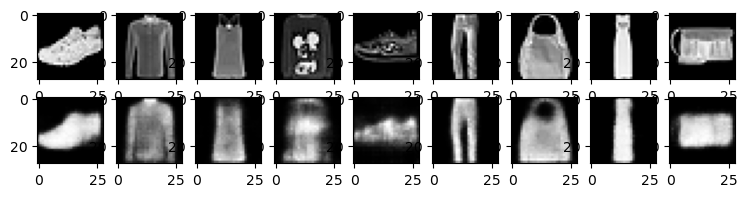

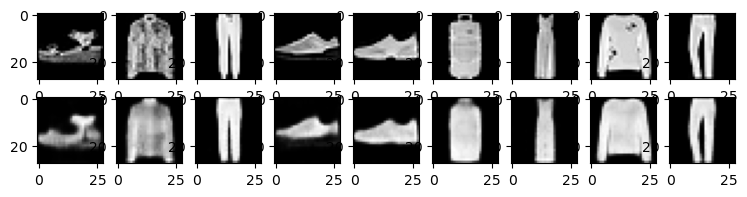

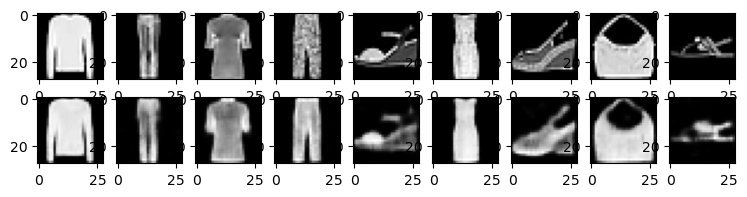

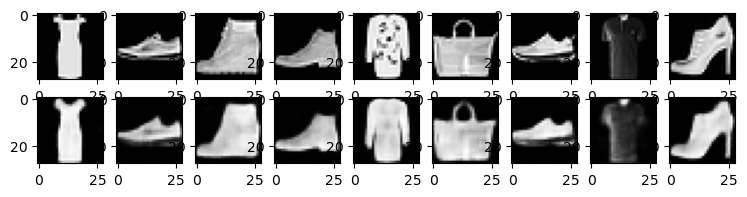

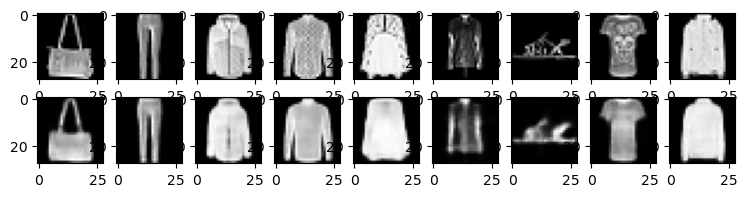

In [10]:
# View Images

for k in range(0, num_epoch, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    plt.axis('off')
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28, 28)
        # item: 1, 28, 28
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        # item = item.reshape(-1, 28, 28)
        # item: 1, 28, 28
        plt.imshow(item[0])
   

### Variational Autoencoder